In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
from functools import partial
from tqdm import tqdm_notebook as tqdm


from models import DeepConditionalModel, InvariantNetwork
from losses import maximum_likelihood_loss
from inn_utils import train_online_ml, compute_metrics
from viz import plot_losses, plot_metrics, plot_variance, plot_metrics_params

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
plt.rcParams['font.size'] = 14

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

In [5]:
tf.enable_eager_execution()

## Bayesian linear regression class

<p>In this example, we train a cINN to approximate the posterior distribution of the regression weights of a Bayesian linear regression model.</p>
<hr>
<p><strong>Setting:</strong></p>
<p>Assume we have observed $n$ pairs of data points:</p>
$$D = \{(\mathbf{x}_{i}, y_{i})\}_{i=1,...,n}$$
<p>where</p>
$$\mathbf{x} \in \mathbb{R}^d, y \in \mathbb{R}$$
<p><strong>Model:</strong></p>
<p>We model each $y_{i}$ as being drawn from a Gaussian distribution paramaterized by:</p>
$$y_{i} \sim \mathcal{N}(\mathbf{\beta}^T\mathbf{x}, a^{-1})$$
<p>where $a$ is the precision, (i.e., inverse variance), so $a = \dfrac{1}{\sigma_{y}^2}$</p>
<p>We place the followng prior on the regression weights:</p>
$$\beta \sim \mathcal{N}_{d}(\mathbf{0}, b^{-1}\mathbf{I}_{d})$$
<p>where $\mathcal{N}_{d}(., .)$ denotes a $d$-dimensional Gaussian distribtuion</p> and $b$ is the precision of the distribution, i.e. $b = \dfrac{1}{\sigma_{\beta}^2}$.
<p>When $a$ and $b$ are known, the likelihood $p(D|\mathbf{\beta})$ is proportional to:</p>
$$p(D|\mathbf{\beta}) \propto \exp(-\dfrac{a}{2}(y - \mathbf{X}\mathbf{\beta})^T(y - \mathbf{X}\mathbf{\beta}))$$
<p>and the posterior of $\mathbf{\beta}$ is proportional to:</p>
$$p(\mathbf{\beta}|D) \propto \exp(-\dfrac{a}{2}(y - \mathbf{X}\mathbf{\beta})^T(y - \mathbf{X}\mathbf{\beta}) - \dfrac{b}{2}\mathbf{\beta}^T\mathbf{\beta})$$
<p>where $X$ is the design matrix in which each row $i$ represents $\mathbf{x}_{i}^T$. Since the prior is conjugate to the likelihood, the posterior is also Gaussian with the following form:</p>
$$p(\mathbf{\beta}|D) = \mathcal{N}_{d}(\mathbf{\beta}|\mathbf{\mu}, \mathbf{\Lambda}^{-1})$$
<p>where $\mathbf{\Lambda}$ is the precision matrix (inverse covariance matrix) and the posterior mean and covariance are calculated as follows:</p>
<br>
$$\mathbf{\Lambda} = a\mathbf{X}^T\mathbf{X} + b\mathbf{I}_{d}$$
$$\mathbf{\mu} = a\mathbf{\Lambda}^{-1}\mathbf{X}^T\mathbf{y}$$
<p>The preceding calculation are implemented in the class <em>BayesianLinearRegression</em> defined below.</p>

In [6]:
class BayesianLinearRegression:
    
    def __init__(self, theta_dim, n_fixed=None, b=1., a=1., use_mvn=True):
        self.theta_dim = theta_dim
        self.b = b # Precision of p(w|b) ~ N(0, b^-1I)
        self.a = a # Precision of p(y | beta.Tx, a^-1)
        self.Ix = np.identity(self.theta_dim)
        if use_mvn:
            self.prior_beta = stats.multivariate_normal(np.zeros(self.theta_dim), (1/self.b) * self.Ix)
        else:
            self.prior_beta = stats.norm(0, 1/self.b)
        self.use_mvn = use_mvn
        
    def _generate_design_mat(self, n_samples):
        return np.random.randn(n_samples, self.theta_dim)
    
    def _sample_beta(self):
        """Prior on beta is a normal N(0, b^-1I)."""
        if self.use_mvn:
            return self.prior_beta.rvs()
        return self.prior_beta.rvs(self.theta_dim)
    
    def generate_data(self, n_samples):
        """Generates a single regression dataset."""
        
        X = self._generate_design_mat(n_samples)
        beta = self._sample_beta()
        y = X @ beta + np.random.normal(0., np.sqrt((1/self.a)), n_samples)
        return np.c_[X, y], beta
    
    def generate_multiple_datasets(self, n_datasets, to_tensor=True, n_points=None):
        """Generates multiple regression datasets by calling generate_data() multiple times."""
        
        # Draw n from U(50, 500), if n not fixed
        if n_points is None:
            n_points = np.random.randint(50, 501)
        
        X = np.zeros((n_datasets, n_points, self.theta_dim+1))
        betas = np.zeros((n_datasets, self.theta_dim))
        
        for i in range(n_datasets):
            D, beta = self.generate_data(n_points)
            X[i] = D
            betas[i] = beta
        if to_tensor:
            return tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(betas, dtype=tf.float32)
        return X, betas
    
    def analytic_means_vars(self, X_test):
        """Computes means and vars of the true posteriors for multiple datasets."""
        
        true_means = np.zeros((X_test.shape[0], self.theta_dim))
        true_vars = np.zeros((X_test.shape[0], self.theta_dim))
        
        for i in range(X_test.shape[0]): 
            post = self.posterior_beta(X_test[i].numpy())
            true_means[i, :] = post.mean
            true_vars[i, :] = np.diag(post.cov)
        return true_means, true_vars
        
    def posterior_beta(self, D, n_samples=None):
        """Computes the posterior of beta given data as described above."""
        
        # Extract X and y
        X = D[:, :self.theta_dim]
        y = D[:, self.theta_dim]
        
        # Compute mean and cov of Gaussian posterior
        cov = np.linalg.inv(self.a * X.T @ X + self.b * self.Ix)
        mu = self.a * cov @ X.T @ y
        
        if n_samples is None:
            return stats.multivariate_normal(mu, cov)
        return stats.multivariate_normal(mu, cov).rvs(n_samples)
    
    def __call__(self, n_datasets, to_tensor=True, n_points=None):
        """Makes instances of the class callable."""
        return self.generate_multiple_datasets(n_datasets, to_tensor=True, n_points=n_points)

# Functions

## Utility Functions

In [7]:
def plot_true_est_posterior(model, reg, n_samples, theta_test, X_test, params_names, 
                            figsize=(15, 20), font_size=12, filename=None):
    """Plots X_test.shape[0] rows of posterior samples vs true means."""
    
    plt.rcParams['font.size'] = font_size
    
    # Initialize figure
    n_sim = theta_test.numpy().shape[0]
    f, axarr = plt.subplots(n_sim, len(params_names), figsize=figsize)
    
    
    # Sample from approximate posterior given current Y
    if model is not None:
        theta_samples = model.sample(X_test, n_samples).numpy()
        theta_samples_means = theta_samples.mean(axis=0)
    
    # For each row 
    for i in range(n_sim):
        
        # Sample from true posterior given current Y
        theta_analytic_samples = reg.posterior_beta(X_test[i].numpy(), n_samples=n_samples)
        theta_analytic_means = theta_analytic_samples.mean(axis=0)
        
        # Extracttrue data generating values
        theta_true = theta_test.numpy()[i]
        
        for j in range(len(params_names)):
            
            # Plot KDE of approximate posterior, of model specified
            if model is not None:
                sns.distplot(theta_samples[:, i, j], kde=True, hist=True, ax=axarr[i, j], 
                             label='Estimated', color='#5c92e8')
            # Plot KDE of analytic posterior
            sns.distplot(theta_analytic_samples[:, j], kde=True, hist=True, ax=axarr[i, j], 
                         label='Analytic', color='#e55e5e')
            
            # Plot lines for approximate mean, analytic mean and true data-generating value
            if model is not None:
                axarr[i, j].axvline(theta_samples_means[i, j], color='#5c92e8')
            axarr[i, j].axvline(theta_analytic_means[j], color='#e55e5e')
            axarr[i, j].axvline(theta_true[j], color='black', label='True')
            axarr[i, j].spines['right'].set_visible(False)
            axarr[i, j].spines['top'].set_visible(False)
            axarr[i, j].get_yaxis().set_ticks([])
            
            # Set title of first row
            if i == 0:
                axarr[i, j].set_title(params_names[j])
            
            if i == 0 and j == 0:
                f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), 
                         shadow=True, ncol=3, fontsize=10, borderaxespad=1)
            
    f.tight_layout()
    f.subplots_adjust(bottom=0.18)
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_density.png".format(filename, theta_test.shape[1]), dpi=600)
        
    plt.show()
    
    
def plot_true_est_scatter(model, reg, n_samples, X_test, theta_test, 
                          params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    # Initialize figure
    f, axarr = plt.subplots(1, len(params_names), figsize=figsize)

    
    # --- Sample parameter from approx posterior and calculate means and vars --- #
    theta_samples = model.sample(X_test, n_samples).numpy()
    theta_samples_means = theta_samples.mean(axis=0)
        
    # --- Compute analytic posterior and extract mean--- #
    theta_true_means = np.zeros_like(theta_test.numpy())
    for i in range(X_test.shape[0]): 
        post = reg.posterior_beta(X_test[i].numpy())
        theta_true_means[i, :] = post.mean

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_samples_means[:, j], theta_true_means[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmse = np.sqrt(np.mean( (theta_samples_means[:, j] - theta_true_means[:, j])**2 ))
        nrmse = rmse / (theta_true_means[:, j].max() - theta_true_means[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        # Compute R2
        r2 = r2_score(theta_true_means[:, j], theta_samples_means[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes, 
                     size=10)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('Estimated mean')
            axarr[j].set_ylabel('Analytic mean')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_scatter.png".format(filename, theta_test.shape[1]), dpi=600)
        
    plt.show()
    
    
def kl_single(model, X_test, reg, n_test, n_samples_posterior):
    """Computes the KL divergence between multiple parameter samples."""
    
    means_true, vars_true = reg.analytic_means_vars(X_test)
    s = model.sample(X_test, n_samples_posterior, to_numpy=True)
    means_theta = s.mean(axis=0)
    vars_theta = np.var(s, axis=0, ddof=1)
    kl = kl_gaussian(means_true, vars_true, means_theta, vars_theta)
    return kl


def kl_gaussian(means_true, vars_true, means_theta, vars_theta):
    """
    Computes the KL divergence between two diagonal Gaussians.
    """
    
    kl = np.log(np.sqrt(vars_theta) / np.sqrt(vars_true))
    kl += (vars_true + (means_true - means_theta)** 2) / (2 * vars_theta) - 0.5
    kl = np.mean(np.sum(kl, axis=-1))
    return kl


def kl_divergence_all_n(model, reg, n_test, n_samples_posterior, p_bar=None, n_min=50, n_max=500):
    """Computes the KL divergence for all numbers of data points used during training."""
    
    ns = np.arange(n_min, n_max+1)
    kls = []
    for n in ns:
        X_test, _ = reg(n_test, n_points=n)
        kl = kl_single(model, X_test, reg, n_test, n_samples_posterior)
        kls.append(kl)
        if p_bar is not None:
            p_bar.update(1)
    return ns, kls


def compute_true_estimated_variance(model, param_names, reg, n_test, n_samples_posterior, 
                                    p_bar=None, n_min=100, n_max=1000):
    """Compute true vs. estimated variance for all n given."""
    variances = {
            'true': {k: [] for k in param_names},
            'estimated': {k: [] for k in param_names},
    }
    ns = np.arange(n_min, n_max+1)
    for n_points in ns:
        
        # Generate data
        X_test, theta_test = reg(n_test, n_points=n_points)
        
         # Sample from approx posterior and compute posterior vars
        theta_approx = model.sample(X_test, n_samples_posterior, to_numpy=True)
        theta_approx_vars = np.mean(np.var(theta_approx, axis=0, ddof=1), axis=0)
        
        # Compute posterior variances
        _, theta_vars = reg.analytic_means_vars(X_test)
        theta_vars = np.mean(theta_vars, axis=0)
        
        # --- Plot true vs estimated posterior means on a single row --- #
        for j, name in enumerate(param_names):
            variances['true'][name].append(theta_vars[j])
            variances['estimated'][name].append(theta_approx_vars[j])
            
        if p_bar is not None:
            p_bar.update(1)
            
    return ns, variances


def plot_joint(model, reg, X_test, param_names, n_test, n_samples_posterior, 
               filename=None, figsize=(10, 6)):
    """
    Plots joint recovery plots on the full test sample.
    """
    
    post_means, _ = reg.analytic_means_vars(X_test)
    to_plot = np.concatenate((post_means, samples), axis=0)
    all_params = pd.DataFrame(to_plot, columns=param_names)
    all_params['Legend'] = ['Analytic'] * n_test + ['Estimated'] * n_test 
    samples = model.sample(X_test, n_samples_posterior, to_numpy=True).mean(0)

    g = sns.PairGrid(all_params, hue="Legend", palette={'Analytic': '#e55e5e', 'Estimated': '#5c92e8'})
    g.map_upper(sns.scatterplot, alpha=0.9)
    g.map_lower(sns.kdeplot, alpha=0.9)
    g.map_diag(sns.distplot, hist=True, hist_kws=dict(edgecolor="k", linewidth=1, alpha=0.9))
    g.add_legend(title="", shadow=True)
    g.fig.set_figwidth(figsize[0])
    g.fig.set_figheight(figsize[1])
    if filename is not None:
        g.savefig('figures/Regression_{}.png'.format(filename), dpi=600)
    
    
def plot_true_est_variance(variances, ns, param_names, figsize=(12, 4), show=True, 
                  xlabel=r'$n$', filename=None, tight=True, std=False, font_size=12):
    """
    Plots posterior variances of parameters as a function of the number of time points.
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Initialize figure
    # Determine figure layout
    if len(param_names) >= 6:
        n_col = int(np.ceil(len(param_names) / 2))
        n_row = 2
    else:
        n_col = int(len(param_names))
        n_row = 1

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat


    for i, p in enumerate(param_names):
        
        if std:
            sns.lineplot(ns, np.sqrt(variances['true'][p]), markers=True, 
                         dashes=False, ax=axarr[i], label='Analytic', color='#e55e5e')
            sns.lineplot(ns, np.sqrt(variances['estimated'][p]), markers=True, 
                         dashes=False, ax=axarr[i], label='Estimated', color='#5c92e8')
        else:
            sns.lineplot(ns, variances['true'][p], markers=True, 
                         dashes=False, ax=axarr[i], label='Analytic', color='#e55e5e')
            sns.lineplot(ns, variances['estimated'][p], markers=True, 
                         dashes=False, ax=axarr[i], label='Estimated', color='#5c92e8')
        
        if i == 0:
            ylabel = 'Posterior variance'
            if std:
                ylabel = 'Posterior std'
            axarr[i].set_ylabel(ylabel)
            axarr[i].set_xlabel(xlabel)
            axarr[i].legend(fontsize=10)
        else:
            axarr[i].get_legend().remove()
            
        axarr[i].set_title(p)
        axarr[i].spines['right'].set_visible(False)
        axarr[i].spines['top'].set_visible(False)

    if tight:
        f.tight_layout()
        
    if show:
        plt.show()
    
    if filename is not None:
        f.savefig("figures/{}_variance.png".format(filename), dpi=600, bbox_inches='tight')
        
        
def plot_joint(model, reg, X_test, param_names, n_test, n_samples_posterior, 
               filename=None, figsize=(10, 6)):
    """
    Plots joint recovery plots on the full test sample.
    """
    
    samples = model.sample(X_test, n_samples_posterior, to_numpy=True).mean(0)
    post_means, _ = reg.analytic_means_vars(X_test)
    to_plot = np.concatenate((post_means, samples), axis=0)
    all_params = pd.DataFrame(to_plot, columns=param_names)
    all_params['Legend'] = ['Analytic'] * n_test + ['Estimated'] * n_test 
    

    g = sns.PairGrid(all_params, hue="Legend", palette={'Analytic': '#e55e5e', 'Estimated': '#5c92e8'})
    g.map_upper(sns.scatterplot, alpha=0.9)
    g.map_lower(sns.kdeplot, alpha=0.9)
    g.map_diag(sns.distplot, hist=True, hist_kws=dict(edgecolor="k", linewidth=1, alpha=0.9))
    g.add_legend(title="", shadow=True)
    g.fig.set_figwidth(figsize[0])
    g.fig.set_figheight(figsize[1])
    if filename is not None:
        g.savefig('figures/Regression_{}.png'.format(filename), dpi=600)

# Train on Bayesian Linear Regression

## Training and Simulation Hyperparameters

In [38]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
train = False
theta_dim = 400
params_names = [r'$\beta_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 1
summary_dim = 128
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_points = 8000
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 5000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)


# ----- Data generation function----- 
bayesian_regression = BayesianLinearRegression(theta_dim, n_fixed=n_points, use_mvn=False)
bayesian_regression = partial(bayesian_regression, n_points=n_points)

## Model and Optimizer

In [39]:
summary_net = InvariantNetwork(summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

##  Checkpoint Manager

In [40]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/regression_400d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


## Test Data

In [41]:
X_test, theta_test = bayesian_regression(2)

## Test Untrained Model

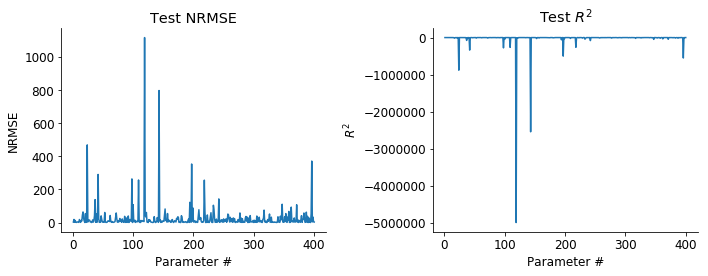

In [42]:
plot_metrics_params(model, X_test, theta_test, n_samples_posterior, n_chunks=10)

## Training the Model

In [46]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        # Run training loop
        train_online_ml(model, optimizer, bayesian_regression, iterations_per_epoch, 
                        batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
                        transform=None, n_smooth=100)
        # Plot stuff
#         plot_metrics_params(model, X_test, theta_test, n_samples_posterior, n_chunks=10)
        
        # Save model
        manager.save()

KeyboardInterrupt: 

In [50]:
theta_approx_means = np.concatenate(
                        [model.sample(X_test, 2000 // 10, to_numpy=True)
                         for _ in range(10)], axis=0).mean(axis=0)

In [54]:
theta_test.shape

TensorShape([Dimension(2), Dimension(400)])

IndexError: index 100 is out of bounds for axis 0 with size 100

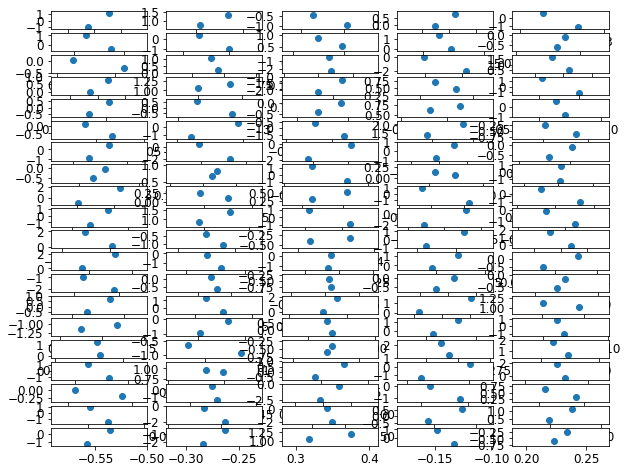

In [55]:
f, ax = plt.subplots(20, 5, figsize=(10, 8))
for i in range(theta_test.shape[1]):
    ax.flat[i].scatter(theta_approx_means[:, i], theta_test[:, i])

# Evaluate the trained model

## Posterior means

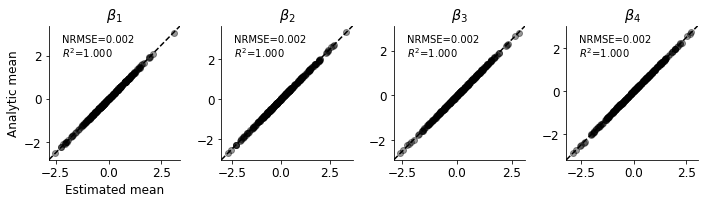

In [187]:
plot_true_est_scatter(model, bayesian_regression, n_samples_posterior, 
                      X_test, theta_test, params_names, figsize=(10, 3),filename='Regression')

## Posterior densities

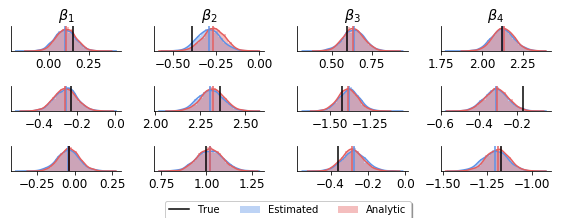

In [139]:
plot_true_est_posterior(model, bayesian_regression, n_samples_posterior, 
                        theta_test2, X_test2, params_names, figsize=(8, 3), filename='Regression')

## Joint plot for posterior means

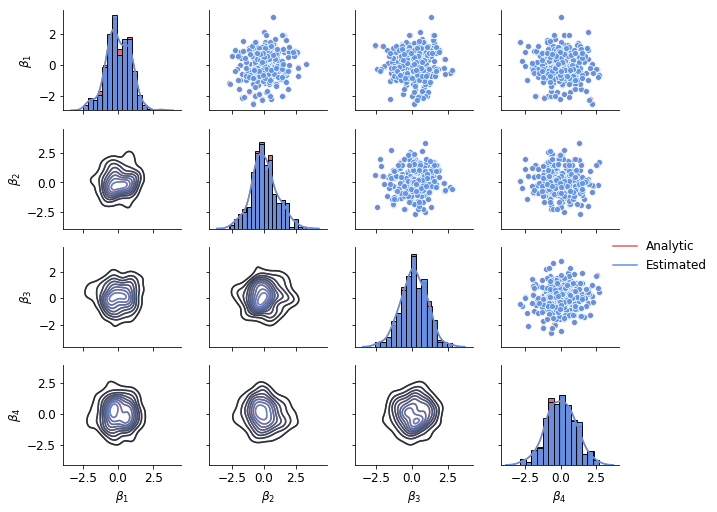

In [225]:
plot_joint(model, bayesian_regression, X_test, params_names, 
           n_test, n_samples_posterior, 'joint', figsize=(10, 7))

## Metrics for all n

In [151]:
n_min=50
n_max=500
with tqdm(total=n_max-n_min, desc='Computation of metrics') as p_bar:
    ns, metrics = compute_metrics(model, params_names, bayesian_regression, n_test, 
                                  n_samples_posterior, p_bar=p_bar, n_min=n_min, n_max=n_max)

### Plot metrics

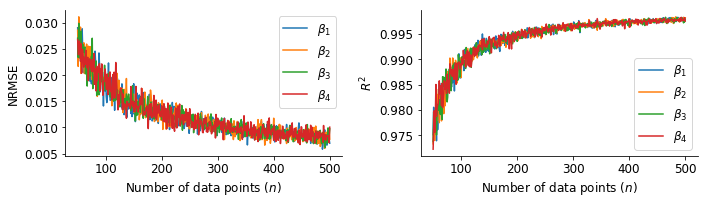

In [169]:
plot_metrics(metrics, ns, params_names, figsize=(10, 3), 
             xlabel=r'Number of data points ($n$)', filename='Regression')

### Plot variance

In [ ]:
n_min=50
n_max=500
with tqdm(total=n_max-n_min, desc='Variance computation') as p_bar:
    ns, variances = compute_true_estimated_variance(model, params_names, bayesian_regression, n_test, 
                                                    n_samples_posterior, p_bar=p_bar, n_min=n_min, n_max=n_max)

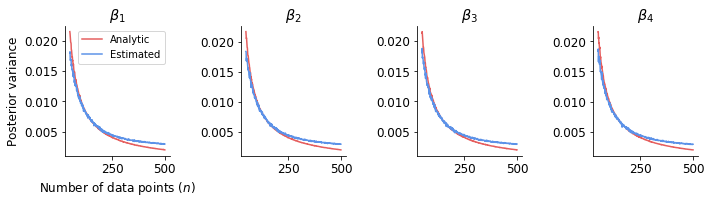

In [220]:
plot_true_est_variance(variances, ns, params_names, figsize=(10, 3), 
                       xlabel=r'Number of data points ($n$)',tight=True, 
                       filename='Regression')

## KL divergence

In [178]:
n_min=50
n_max=500
with tqdm(total=n_max-n_min, desc='KL computation') as p_bar:
    ns, kls = kl_divergence_all_n(model, bayesian_regression, n_test, n_samples_posterior, p_bar=p_bar)

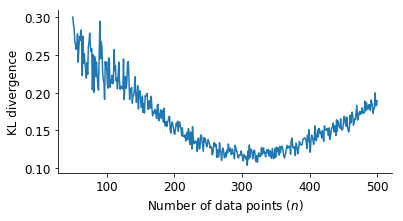

In [211]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(ns, kls, markers=True, dashes=False, ax=ax)
ax.set_xlabel(r'Number of data points ($n$)')
ax.set_ylabel('KL divergence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.savefig('figures/Regression_kl.png', dpi=600, bbox_inches='tight')

## Speed of inference

In [11]:
n_speed = 1000
X_test3, theta_test3 = bayesian_regression(n_speed, n_points=500)

In [16]:
%timeit model.sample(X_test3, n_samples_posterior)

5.48 s ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
